# 3. Topic Modeling
In this notebook we will perform the initial topic modeling of the COVID and Agriculture datasets for the publications track of Hercules project. This phase will consist on the preprocessing of each dataset and the training of several topic models to infer the topics of each corpus.

## Setup

In [2]:
%run __init__.py

INFO:root:Starting logger


In [3]:
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

## Common functions

Before we start working with our first dataset, we are going a common set of functionality that will be used in both datasets. First of all, we will define a function to print a word cloud based on the given text:

In [4]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt


def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


We also will implement a custom class to perform the preprocessing of texts before they are used by the topic extraction models. This preprocessing will consist of the tokenization of each text, stop word removal and lemmatization. The [Spacy](https://spacy.io) library will be used for this task. Our TextPreprocessor class will allow the use of a custom Spacy model for each different dataset, as we will see later:

In [5]:
from herc_common.text import TextPreprocessor

The following function will be used to show the top terms of each topic extracted by a given model:

In [6]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


This next set of functions will be use to evaluate our topic extraction models after they have been trained. In the first cell we are making use of the [tmtoolkit](https://tmtoolkit.readthedocs.io/en/latest/) library to obtain the topic coherence of a given model. Specifically, we will be using the _u\_mass_ measure.

The second cell consists of a list of functions to try out several combinations of topics for each given model, and return the model with the best topic coherence amongst them.

In [7]:
import numpy as np

from tmtoolkit.topicmod.evaluate import metric_coherence_gensim


def base_scoring_function(vectorizer, texts, model, X, top_n=10):
    return metric_coherence_gensim(measure='u_mass', dtm=X, 
                                   topic_word_distrib=model.components_,
                                   vocab=np.array([x for x in vectorizer.vocabulary_.keys()]), 
                                   texts=texts, return_mean=True)

In [8]:
MIN_TOPICS = 3
MAX_TOPICS = 30

def try_topics(model_cls, X, scoring_func, **kwargs):
    res = {}
    for num_topics in range(MIN_TOPICS, MAX_TOPICS):
        model = model_cls(n_components=num_topics, random_state=RANDOM_SEED, **kwargs)
        model.fit(X)
        score = scoring_func(model, X)
        res[model] = score
    return res

def print_results_info(model_results):
    best_model = get_best_model(model_results)
    print(f"Best model parameters: {best_model.get_params()}")
    print(f"Topic coherence: {model_results[best_model]}")

def get_best_model(model_results):
    return max(model_results, key=model_results.get)


Finally, we will define a final function to serialize our pipelines so we can load them later on in the following notebooks to obtain the topics of a given piece of text:

In [9]:
from herc_common.utils import save_object

Now that we have defined our common set of functions, we can start working on each dataset.

## Agriculture

### Loading the dataframe

In [10]:
DF_FILE_PATH = os.path.join(NOTEBOOK_2_RESULTS_DIR, 'protocols_dataframe.pkl')

df = pd.read_pickle(DF_FILE_PATH)

### Preprocessing text

In [11]:
protocols = df['full_text_cleaned'].values

In [12]:
import en_core_web_sm
import en_core_web_md

import en_core_sci_lg

custom_stop_words = {"introduction", "fig", "figure", "figures" "figs", "min", "add", "remove", "sample"}

preprocessor = TextPreprocessor(en_core_web_md, custom_stop_words)
preprocessed_texts = preprocessor.fit_transform(protocols)

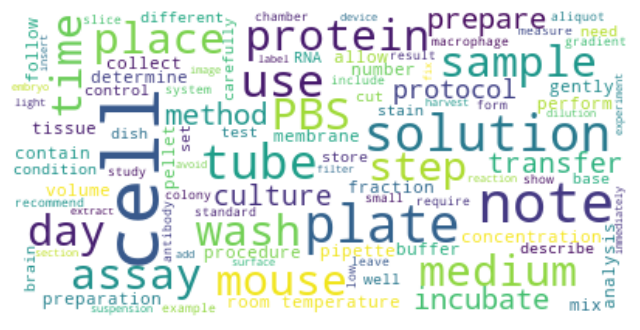

In [13]:
complete_text = ' '.join([' '.join(token) for token in preprocessed_texts])

plot_word_cloud(complete_text)

### LDA

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

def dummy(doc):
    return doc


tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tf = tf_vectorizer.fit_transform(preprocessed_texts)

In [15]:
from functools import partial

from sklearn.decomposition import LatentDirichletAllocation


lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tf_vectorizer,
                                        texts=preprocessed_texts, model=clf, X=X)


lda_results = try_topics(LatentDirichletAllocation, dtm_tf, lda_scoring_func)#, max_iter=100)
lda_results

/Users/laika/.envs/edma/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6958 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 54279 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6958 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 54279 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6958 unique tokens: ['Measurement', 'Chlorop

{LatentDirichletAllocation(n_components=3, random_state=42): -1.9843188262111298,
 LatentDirichletAllocation(n_components=4, random_state=42): -1.8927828222074312,
 LatentDirichletAllocation(n_components=5, random_state=42): -2.2692014514102596,
 LatentDirichletAllocation(n_components=6, random_state=42): -2.179166792941895,
 LatentDirichletAllocation(n_components=7, random_state=42): -2.5279177688311925,
 LatentDirichletAllocation(n_components=8, random_state=42): -2.3796417160835466,
 LatentDirichletAllocation(n_components=9, random_state=42): -2.6436985144487446,
 LatentDirichletAllocation(random_state=42): -2.310172518488023,
 LatentDirichletAllocation(n_components=11, random_state=42): -2.452430179351069,
 LatentDirichletAllocation(n_components=12, random_state=42): -3.0017902043575866,
 LatentDirichletAllocation(n_components=13, random_state=42): -2.931263697665516,
 LatentDirichletAllocation(n_components=14, random_state=42): -3.0897999540856276,
 LatentDirichletAllocation(n_com

In [16]:
print_results_info(lda_results)
best_lda_model = get_best_model(lda_results)

Best model parameters: {'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 4, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 42, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
Topic coherence: -1.8927828222074312


Visualization. Do this with the best model obtained before.

In [16]:
best_lda_model = LatentDirichletAllocation(n_components=9, random_state=RANDOM_SEED)
best_lda_model.fit(dtm_tf)

LatentDirichletAllocation(n_components=9, random_state=42)

In [17]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 10)

Topic #0: cell medium plate tube culture PBS solution wash time protein
Topic #1: tube solution note place cell sample tissue device time RNA
Topic #2: slice chamber gene brain ACSF solution micropump synaptic control flow
Topic #3: fraction membrane protein tube note pellet solution use gradient sample



In [18]:
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tf, tf_vectorizer, mds='tsne')

INFO:numexpr.utils:NumExpr defaulting to 6 threads.


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      269.562408 -124.803398       1        1  45.887942
1        1.782994 -295.079681       2        1  26.347922
3      220.811432 -343.832123       3        1  14.485027
2       50.533993  -76.050934       4        1  13.279108, topic_info=          Term         Freq        Total Category  logprob  loglift
2538      cell  1194.000000  1194.000000  Default  30.0000  30.0000
6090     slice    74.000000    74.000000  Default  29.0000  29.0000
3739  fraction   117.000000   117.000000  Default  28.0000  28.0000
4623    medium   419.000000   419.000000  Default  27.0000  27.0000
4632  membrane   134.000000   134.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
6044      show    19.883753    71.800113   Topic4  -5.8930   0.7350
5536   protein    23.496347   249.680581   Topic4  -5.7261  -0.3444
6264      step    20.642774   167.295767   Topic4  -5.8555  -0.0734
5635      rate    18.336186    52.240998   Topic4  -5.9740   0.9720
2053     allow    17.944850   114.142354   Topic4  -5.9956   0.1688

[316 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1         4  0.952551      AAV
3         4  0.991913     ACSF
94        4  0.952571  Arduino
206       2  0.928292   Bregma
365       2  0.933582     Cyto
...     ...       ...      ...
6893      2  0.959687    wheel
6936      1  0.195995    yield
6936      2  0.163329    yield
6936      3  0.587984    yield
6936      4  0.065332    yield

[554 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

In [23]:
from sklearn.pipeline import Pipeline

lda_pipeline = Pipeline([('preprocessing', preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lda_model)])

lda_protocols_pipe_filename = "protocols_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lda_protocols_pipe_filename))

In [24]:
dtm_tf_filename = "protocols_dtm_tf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_3_RESULTS_DIR, dtm_tf_filename))

#### LDA with bigrams

In [19]:
bigram_tf_vectorizer = CountVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 2))
bigram_dtm_tf = bigram_tf_vectorizer.fit_transform(preprocessed_texts)


bigram_lda_scoring_func = lambda clf, X: base_scoring_function(vectorizer=bigram_tf_vectorizer,
                                                               texts=preprocessed_texts, model=clf, X=X)


bigram_lda_results = try_topics(LatentDirichletAllocation, bigram_dtm_tf, bigram_lda_scoring_func)
bigram_lda_results

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(46887 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 108964 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(46887 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 108964 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(46887 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 108964 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(

{LatentDirichletAllocation(n_components=7, random_state=42): -2.6891870207813287,
 LatentDirichletAllocation(n_components=8, random_state=42): -2.614777838950059,
 LatentDirichletAllocation(n_components=9, random_state=42): -2.758571659818253,
 LatentDirichletAllocation(random_state=42): -2.6108567825608104,
 LatentDirichletAllocation(n_components=11, random_state=42): -3.4819875589457268,
 LatentDirichletAllocation(n_components=12, random_state=42): -3.416422566482177,
 LatentDirichletAllocation(n_components=13, random_state=42): -2.8503528073725026,
 LatentDirichletAllocation(n_components=14, random_state=42): -3.070938064524982,
 LatentDirichletAllocation(n_components=15, random_state=42): -3.3182348125968115,
 LatentDirichletAllocation(n_components=16, random_state=42): -3.0925966716334274,
 LatentDirichletAllocation(n_components=17, random_state=42): -2.7178098346184676,
 LatentDirichletAllocation(n_components=18, random_state=42): -3.6443858522248465,
 LatentDirichletAllocation(n

In [20]:
# best_bigram_lda_model = get_best_model(bigram_lda_results)
best_bigram_lda_model = LatentDirichletAllocation(n_components=12)
best_bigram_lda_model.fit_transform(bigram_dtm_tf)

pyLDAvis.sklearn.prepare(best_bigram_lda_model, bigram_dtm_tf, bigram_tf_vectorizer, mds='tsne')

INFO:numexpr.utils:NumExpr defaulting to 6 threads.


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9        5.310529  171.049652       1        1  16.291607
6      136.304657   23.800941       2        1  14.711756
5      101.190552  -84.985191       3        1  11.270446
11    -106.824867  148.841736       4        1  10.780450
8      -44.365761   78.632721       5        1   8.107574
2       43.884090   73.474022       6        1   7.090537
0      114.093971  135.933029       7        1   6.822162
4     -119.727142  -72.077179       8        1   6.792599
1      -49.518208   -9.617325       9        1   6.707071
10    -141.938736   40.055210      10        1   6.335600
7       38.731544  -14.776019      11        1   3.273819
3      -10.944340 -107.193344      12        1   1.816380, topic_info=           Term        Freq       Total Category  logprob  loglift
10915      cell  942.000000  942.000000  Default  30.0000  30.0000
32686     plate  238.000000  238.000000  Default  29.0000  29.0000
27188    medium  313.000000  313.000000  Default  28.0000  28.0000
37470    sample  342.000000  342.000000  Default  27.0000  27.0000
11682   chamber   82.000000   82.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
40587  staining    2.719137   61.140649  Topic12  -6.5901   0.8955
25304      leaf    2.046360   13.905025  Topic12  -6.8744   2.0921
7219      allow    2.382748   91.823688  Topic12  -6.7222   0.3567
41460     study    2.046361   51.644744  Topic12  -6.8744   0.7800
31949     phase    2.046361   46.702070  Topic12  -6.8744   0.8806

[832 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
2          1  0.938937             AAV
14         2  0.988640            ACSF
54         3  0.934887            ADCC
73         7  0.762224             AIR
84         3  0.269553             APC
...      ...       ...             ...
46806      6  0.941874  yield solution
46848      1  0.871674          zygote
46865      5  0.688768            µmol
46865      6  0.086096            µmol
46865      8  0.086096            µmol

[1975 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 6, 12, 9, 3, 1, 5, 2, 11, 8, 4])

In [21]:
bigram_lda_pipeline = Pipeline([('preprocessing', preprocessor),
                                ('vectorizer', bigram_tf_vectorizer),
                                ('model', best_bigram_lda_model)])

lda_bigram_agriculture_pipe_filename = "agriculture_bigram_lda_model.pkl"
save_object(lda_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lda_bigram_agriculture_pipe_filename))

NameError: name 'agriculture_preprocessor' is not defined

### Latent Semantic Analysis (LSA)

In [29]:
from sklearn.decomposition import TruncatedSVD

lsa_scoring_func = lda_scoring_func

lsa_results = try_topics(TruncatedSVD, dtm_tf, lsa_scoring_func)
lsa_results

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6961 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 55784 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6961 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 55784 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6961 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 55784 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6961 u

{TruncatedSVD(n_components=5, random_state=42): -1.5303056037847476,
 TruncatedSVD(n_components=6, random_state=42): -1.9887696903711471,
 TruncatedSVD(n_components=7, random_state=42): -2.476322965839185,
 TruncatedSVD(n_components=8, random_state=42): -2.9349623632867243,
 TruncatedSVD(n_components=9, random_state=42): -2.87690654169821,
 TruncatedSVD(n_components=10, random_state=42): -3.2538781752604775,
 TruncatedSVD(n_components=11, random_state=42): -3.1966187186057153,
 TruncatedSVD(n_components=12, random_state=42): -3.2784447091962448,
 TruncatedSVD(n_components=13, random_state=42): -3.3612554330778557,
 TruncatedSVD(n_components=14, random_state=42): -3.6175734589831814,
 TruncatedSVD(n_components=15, random_state=42): -3.907430424268183,
 TruncatedSVD(n_components=16, random_state=42): -3.588678903682186,
 TruncatedSVD(n_components=17, random_state=42): -3.8454665078013353,
 TruncatedSVD(n_components=18, random_state=42): -3.757793155115025,
 TruncatedSVD(n_components=19, 

In [30]:
print_results_info(lsa_results)
best_lsa_model = get_best_model(lsa_results)

Best model parameters: {'algorithm': 'randomized', 'n_components': 5, 'n_iter': 5, 'random_state': 42, 'tol': 0.0}
Topic coherence: -1.5303056037847476


In [31]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(best_lsa_model, tf_feature_names, 10)

Topic #0: cell min tube medium sample add solution note plate protein
Topic #1: slice chamber ACSF micropump synaptic interface long connect hippocampu term
Topic #2: sample tube fraction protein gradient use centrifuge solution standard note
Topic #3: fraction protein cell gradient membrane pellet tag buffer organelle labeling
Topic #4: plate medium Day pre add day min culture neuron note



In [32]:
from sklearn.decomposition import TruncatedSVD

lsa_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tf_vectorizer),
                         ('model', best_lsa_model)])

lsa_agriculture_pipe_filename = "agriculture_lsa_model.pkl"
save_object(lsa_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, lsa_agriculture_pipe_filename))

NameError: name 'agriculture_preprocessor' is not defined

### NMF

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(preprocessor=dummy, tokenizer=dummy, ngram_range=(1, 1))
dtm_tfidf = tfidf_vectorizer.fit_transform(preprocessed_texts)

In [37]:
from sklearn.decomposition import NMF

nmf_scoring_func = lambda clf, X: base_scoring_function(vectorizer=tfidf_vectorizer,
                                                        texts=preprocessed_texts, model=clf, X=X)

nmf_results = try_topics(NMF, dtm_tfidf, nmf_scoring_func, max_iter=900)
nmf_results

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6959 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 980 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6959 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 980 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6959 unique tokens: ['Measurement', 'Chlorophyll', 'Carotenoids', 'Concentration', 'Cyanobacteria']...) from 100 documents (total 980 corpus positions)
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(6959 unique 

{NMF(max_iter=900, n_components=5, random_state=42): -3.472701715150034,
 NMF(max_iter=900, n_components=6, random_state=42): -3.4745006063058543,
 NMF(max_iter=900, n_components=7, random_state=42): -4.3706423464654875,
 NMF(max_iter=900, n_components=8, random_state=42): -4.510234562323457,
 NMF(max_iter=900, n_components=9, random_state=42): -4.50501571977722,
 NMF(max_iter=900, n_components=10, random_state=42): -4.674029034346114,
 NMF(max_iter=900, n_components=11, random_state=42): -4.5232956094795025,
 NMF(max_iter=900, n_components=12, random_state=42): -4.46495494426717,
 NMF(max_iter=900, n_components=13, random_state=42): -4.016708711119238,
 NMF(max_iter=900, n_components=14, random_state=42): -4.595230308433206,
 NMF(max_iter=900, n_components=15, random_state=42): -5.222124893841988,
 NMF(max_iter=900, n_components=16, random_state=42): -5.13162117021229,
 NMF(max_iter=900, n_components=17, random_state=42): -5.388172835255354,
 NMF(max_iter=900, n_components=18, random_

In [35]:
print_results_info(nmf_results)
best_nmf_model = get_best_model(nmf_results)

Best model parameters: {'alpha': 0.0, 'beta_loss': 'frobenius', 'init': None, 'l1_ratio': 0.0, 'max_iter': 300, 'n_components': 5, 'random_state': 42, 'shuffle': False, 'solver': 'cd', 'tol': 0.0001, 'verbose': 0}
Topic coherence: -3.472701715150034


In [ ]:
best_nmf_model = NMF(n_components=29, max_iter=400, random_state=RANDOM_SEED)
best_nmf_model.fit(dtm_tfidf)

In [36]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(best_nmf_model, tfidf_feature_names, 10)

Topic #0: cell ROS PBS staining stain assay wash FACS plate spin
Topic #1: protein membrane fraction buffer bead pellet antibody gradient tag lysis
Topic #2: brain mouse section solution tissue slice embryo antibody PBS cochlea
Topic #3: cell medium plate differentiation dish day ebs device culture colony
Topic #4: sample plant root tube solution standard centrifuge activity nematode gradient



In [ ]:
from sklearn.pipeline import Pipeline

nmf_pipeline = Pipeline([('preprocessing', agriculture_preprocessor),
                         ('vectorizer', tfidf_vectorizer),
                         ('model', best_nmf_model)])

nmf_agriculture_pipe_filename = "agriculture_nmf_model.pkl"
save_object(nmf_pipeline, os.path.join(NOTEBOOK_3_RESULTS_DIR, nmf_agriculture_pipe_filename))

In [ ]:
dtm_tfidf_filename = "agriculture_dtm_tfidf.pkl"

save_object(dtm_tf, os.path.join(NOTEBOOK_3_RESULTS_DIR, dtm_tfidf_filename))